# DeepCovid Data Reconstruction 

This notebook demonstrates a proof-of-concept for how adversaries can possibly reconstruct the image data by exploiting the gradients from neural network. We use the DeepCovid dataset with a simple neural network architecture. This notebook presents the two equivalent codes based on Pytorch and Tensorflow.

The code is adopted from https://colab.research.google.com/drive/17uB-plUyxNo19HVJBOKGDVWo88IiR74o?usp=sharing.

# Helper functions

In [1]:
# we should scale down the positive weights
def generate_symmetric_points(num_elements, down_scale_factor=0.95, mu=0.0, sigma=0.5):
    """num_pos says roughly how many positive elements we want to have"""

    vector = np.random.normal(mu, sigma, num_elements)

    # make all negative (such that we can better control)
    abs_vector = abs(vector) * (-1)

    num_pos = np.floor(num_elements / 2).astype(int)

    # random positive indices
    pos_indices = np.random.choice(num_elements, num_pos, replace=False)

    negative_elements = np.delete(abs_vector, pos_indices)

    abs_vector[pos_indices] = -down_scale_factor * negative_elements  # set the negative values and turn them positive

    return abs_vector

def weight_initializer(weights_shape, initializer_function, **kwargs):
    """
    Will generate the weights in weight_shape, by filling each row with the given initializer function
    :param weights_shape: shape of the final weights (shape[0] are usually our data features, shape[1] are the number of
    neurons in the next layer
    :param initializer_function: a function that fills every every row in the weight matrix
    :return: initialized weights
    """
    # weight shape will be input-features (our data), output features

    row_length = weights_shape[0]
    number_rows = weights_shape[1]

    weights = np.zeros((row_length, number_rows))
    for i in range(number_rows):
        weights[:, i] = initializer_function(row_length, **kwargs)

    return weights

In [2]:
def reconstruct_from_gradients(gradient, bias):
    inverse_bias = 1/bias
    rescaled_gradients = gradient * inverse_bias
    rescaled_gradients = rescaled_gradients[:,~np.isnan(rescaled_gradients).any(axis=0)].T
    return rescaled_gradients

# Reconstruction in Pytorch

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torchvision import datasets, transforms
import numpy as np

In [4]:
IMG_SIZE=64
BATCH_SIZE=32
CHANNELS=3
FEATURES = CHANNELS*IMG_SIZE*IMG_SIZE
SHAPE=(IMG_SIZE,IMG_SIZE,CHANNELS)
NUM_NEURONS = FEATURES*2
DEVICE="cpu"

## Loading the DeepCovid data

In [5]:
data_dir = "data_upload_v3/train"
transform = transforms.Compose([
#     transforms.Grayscale(num_output_channels=CHANNELS),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

### Permuting the data dimensions

In [6]:
images, labels = next(iter(dataloader))
images = images.permute(0, 2, 3, 1)
images.shape, labels.shape

(torch.Size([32, 64, 64, 3]), torch.Size([32]))

### Plotting some images

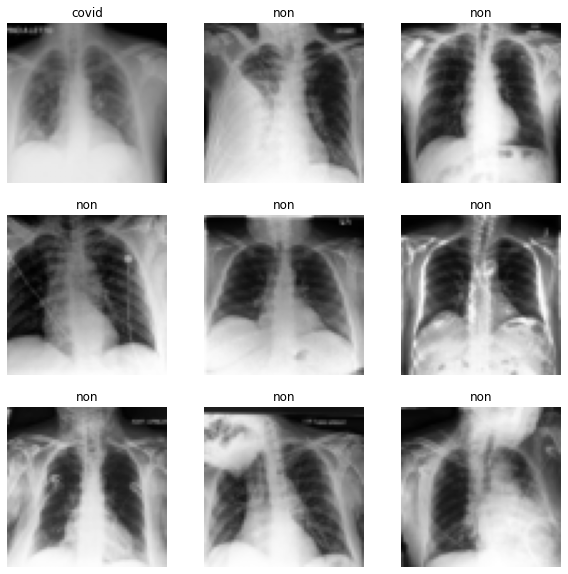

In [7]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy())
    plt.title(dataset.classes[labels[i]])
    plt.axis("off")

## Defining a simple model 

In [8]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(FEATURES, NUM_NEURONS),
            nn.ReLU(),
            nn.Linear(NUM_NEURONS, 2),
        )
        
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

## Experimenting random initialization

We create the simple model for the experiment and take one iteration of forward and backward to get gradients for each layer.

In [9]:
model = SimpleModel()
model.linear_relu_stack[1].weight.data.normal_(std=0.5)
model.linear_relu_stack[1].bias.data.normal_(std=0.5)
print(model)

SimpleModel(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12288, out_features=24576, bias=True)
    (2): ReLU()
    (3): Linear(in_features=24576, out_features=2, bias=True)
  )
)


In [10]:
y_pred = model(images)
loss = nn.CrossEntropyLoss()
output = loss(y_pred, labels)
model.zero_grad()
output.backward()

Try reconstructing data by using gradients. This is simply done by rescaling the gradient of the first layer.

In [11]:
layer1 = model.linear_relu_stack[1]
rescaled_gradients = reconstruct_from_gradients(
    layer1.weight.grad.detach().numpy().T, 
    layer1.bias.grad.detach().numpy()
)

/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:2: RuntimeWarning: divide by zero encountered in true_divide
  inverse_bias = 1/bias
/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:3: RuntimeWarning: invalid value encountered in multiply
  rescaled_gradients = gradient * inverse_bias


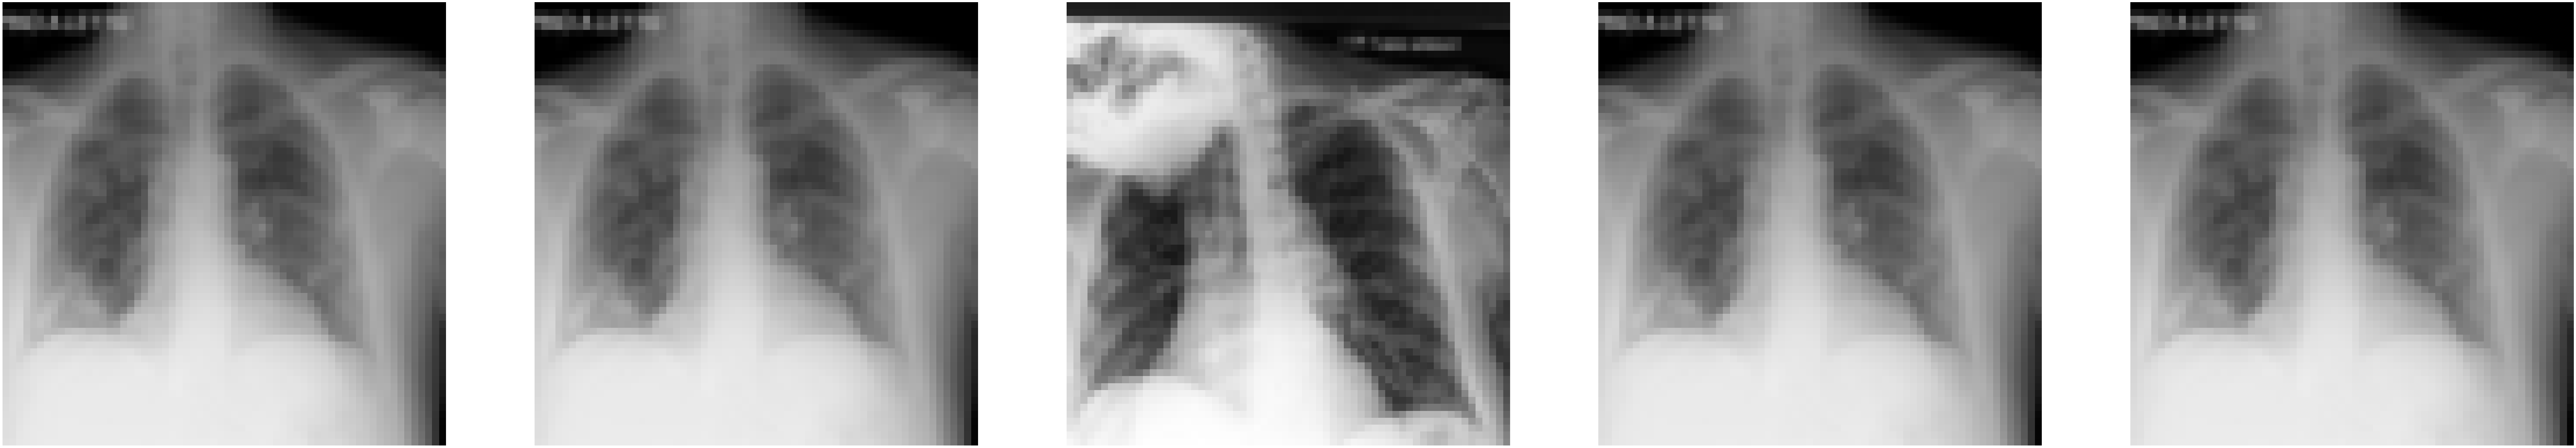

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(128,128))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(rescaled_gradients[i].reshape(SHAPE))

## Experimenting adversarial Initialization

In this experiment, we initialize the first layer of the model in a certain way as from the adversary side.

In [13]:
model = SimpleModel()
initializer = generate_symmetric_points
hyperparameter = {'down_scale_factor': 0.95}
weights_shape = (FEATURES, NUM_NEURONS)
weights = weight_initializer(weights_shape, initializer, **hyperparameter) #todo pass the kwargs
bs = np.zeros(NUM_NEURONS)
model.linear_relu_stack[1].weight.data = torch.Tensor(weights.T)
model.linear_relu_stack[1].bias.data = torch.Tensor(bs)

Then, again we take one forward and backward iteration to get the gradients.

In [14]:
y_pred = model(images)
loss = nn.CrossEntropyLoss()
output = loss(y_pred, labels)
model.zero_grad()
output.backward()

In [15]:
layer1 = model.linear_relu_stack[1]
rescaled_gradients = reconstruct_from_gradients(
    layer1.weight.grad.detach().numpy().T, 
    layer1.bias.grad.detach().numpy()
)

/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:2: RuntimeWarning: divide by zero encountered in true_divide
  inverse_bias = 1/bias
/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:3: RuntimeWarning: invalid value encountered in multiply
  rescaled_gradients = gradient * inverse_bias


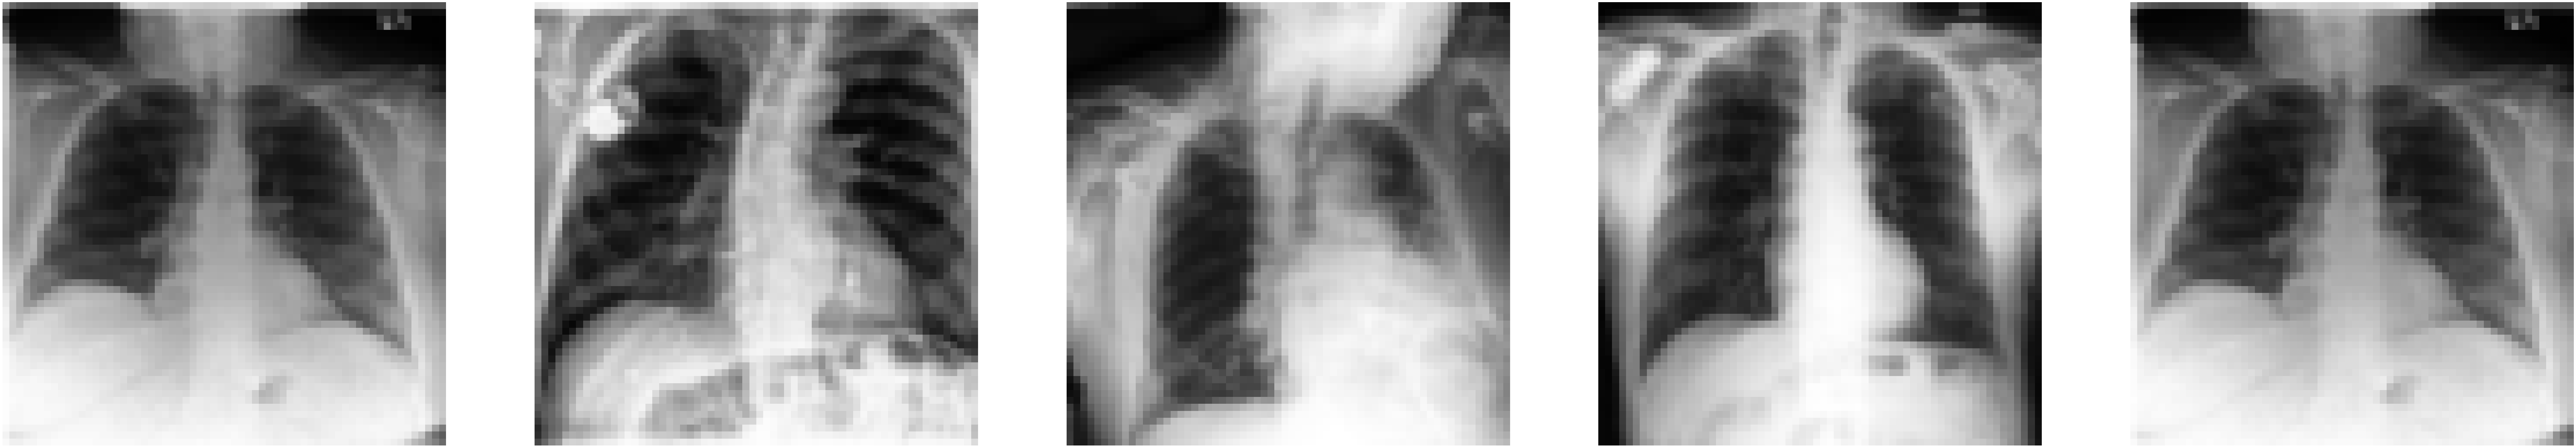

In [16]:
fig, axes = plt.subplots(1, 5, figsize=(128,128))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(rescaled_gradients[i].reshape(SHAPE))

## Impact of differential privacy on reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


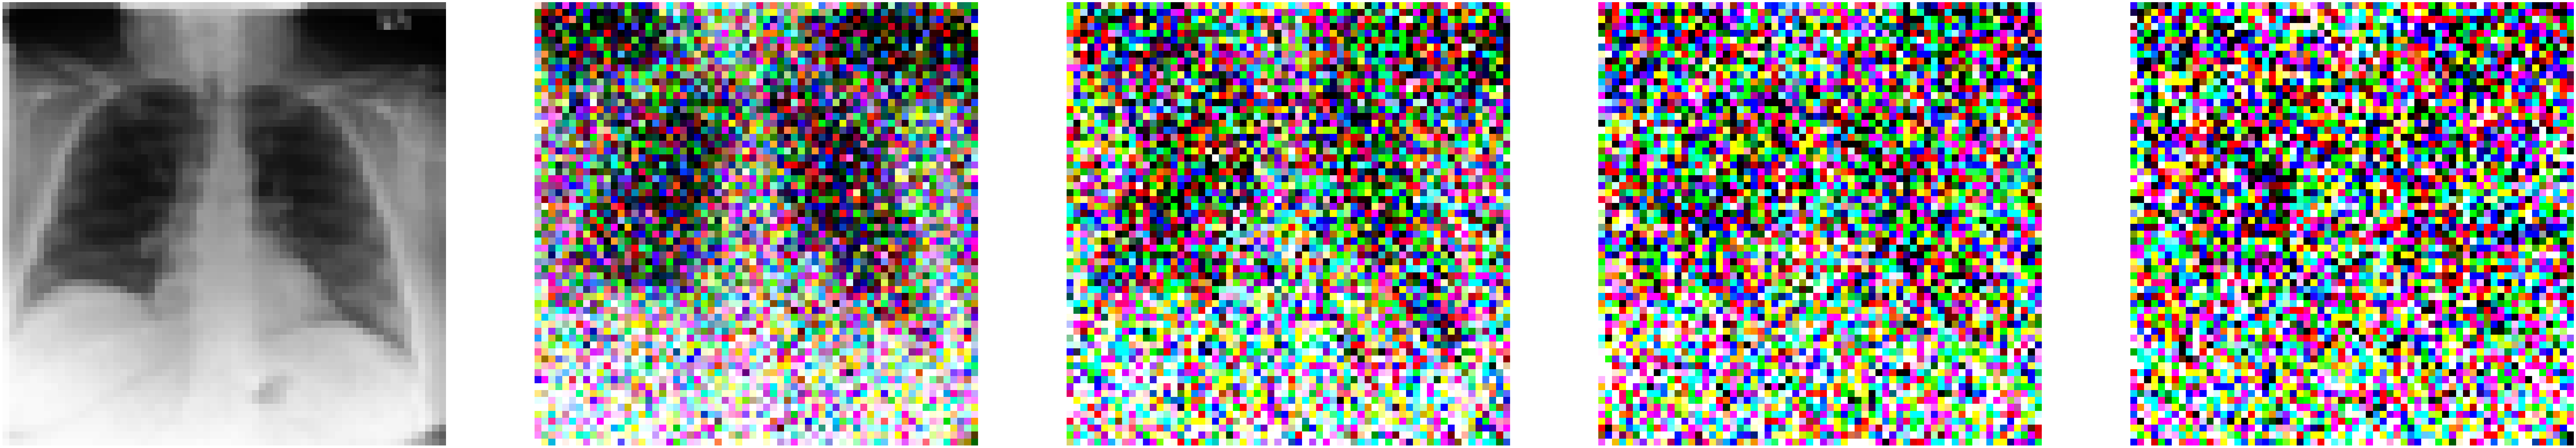

In [17]:
noise_multiplier = 0.35
fig, axes = plt.subplots(1, 5, figsize=(128,128))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    rescaled_noisy_gradients = rescaled_gradients[0] + np.random.laplace(scale=i*noise_multiplier, size=rescaled_gradients[0].shape)
    ax.imshow(rescaled_noisy_gradients.reshape(SHAPE))
    
# plt.savefig('xray_dp.pdf')

# Tensorflow

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Flatten, Dense

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(IMG_SIZE,IMG_SIZE)
)
class_names = train_ds.class_names

Found 2084 files belonging to 2 classes.


2022-03-11 12:37:44.251345: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
train_ds.batch(BATCH_SIZE)
for element in train_ds.as_numpy_iterator():
    train_data = element[0]
    train_labels = element[1]
    break
train_data = train_data / 255.0
train_data.shape

(32, 64, 64, 3)

In [21]:
train_data_flat = train_data.reshape(BATCH_SIZE,FEATURES)

In [22]:
tf_model = Sequential()
tf_model.add(Dense(
    NUM_NEURONS, 
    activation='relu', 
    kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.5)
))
tf_model.add(Dense(2))
tf_model.build((None,FEATURES))

In [23]:
initializer = generate_symmetric_points
hyperparameter = {'down_scale_factor': 0.95}
weights_shape = (FEATURES, NUM_NEURONS)
tf_weights = weight_initializer(weights_shape, initializer, **hyperparameter) #todo pass the kwargs
bs = np.zeros(NUM_NEURONS)
tf_model.layers[0].set_weights([tf_weights, bs])

In [24]:
x = train_data_flat
y = train_labels
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
with tf.GradientTape() as tape:
    logits = tf_model(x)
    loss_value = loss(y, logits)
    gradients = tape.gradient(loss_value, tf_model.trainable_weights)

## Data reconstruction from gradients

In [25]:
rescaled_gradients = reconstruct_from_gradients(
    gradients[0].numpy(),
    gradients[1].numpy()
)

/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:2: RuntimeWarning: divide by zero encountered in true_divide
  inverse_bias = 1/bias
/var/folders/sq/w0_5ndd53_vb3fcbzs_6skfw0000gn/T/ipykernel_82208/3363450496.py:3: RuntimeWarning: invalid value encountered in multiply
  rescaled_gradients = gradient * inverse_bias


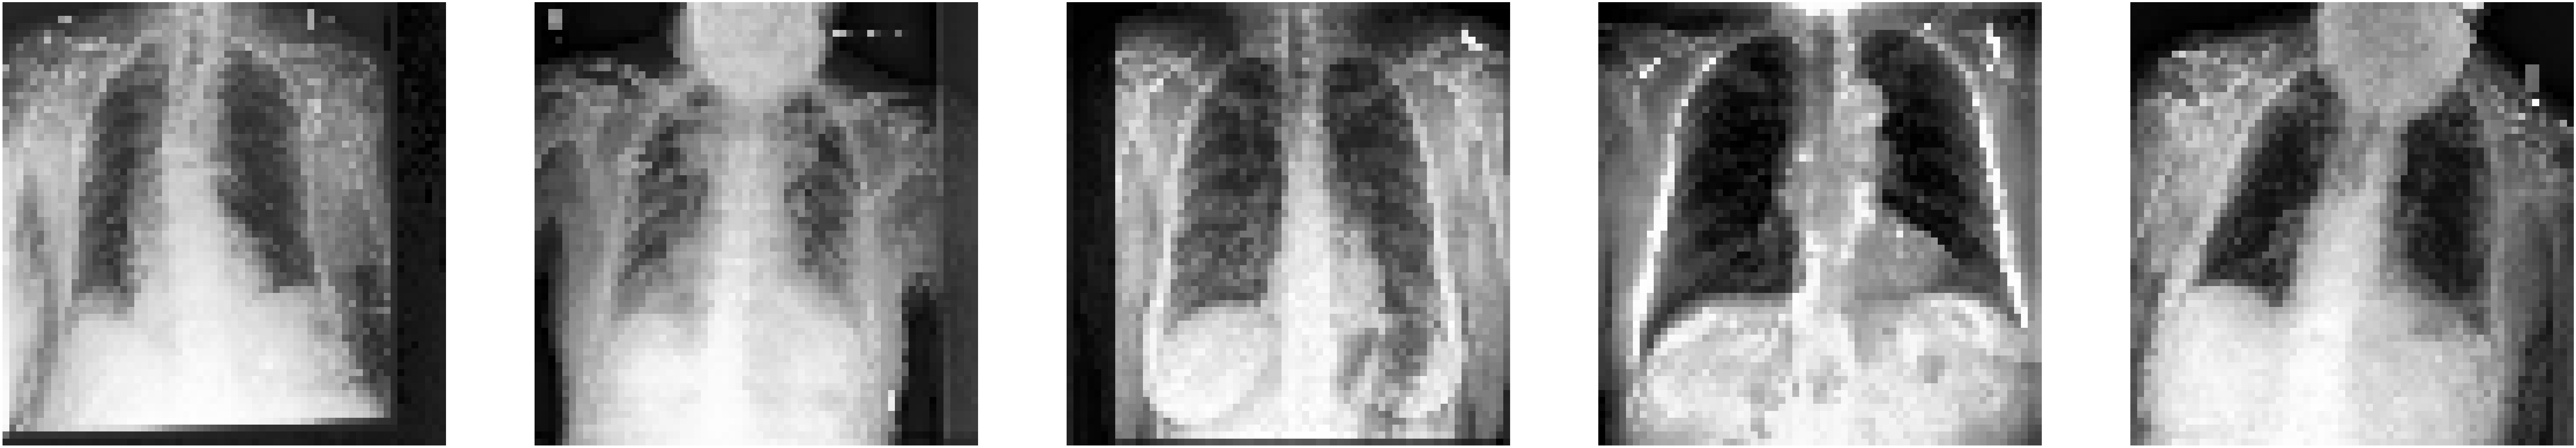

In [26]:
fig, axes = plt.subplots(1, 5, figsize=(128,128))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(rescaled_gradients[i].reshape(SHAPE))

## Impact of differential privacy on reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


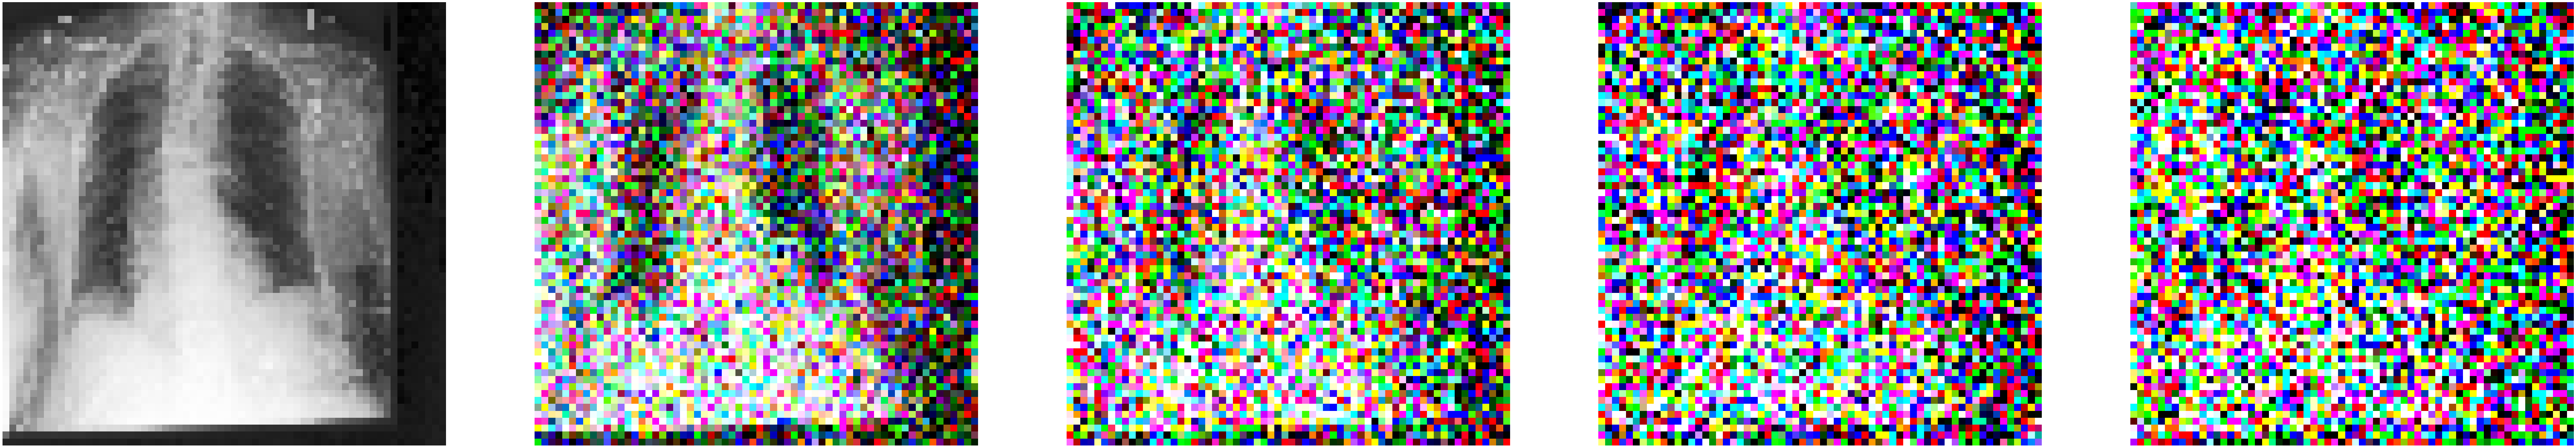

In [27]:
noise_multiplier = 0.35
fig, axes = plt.subplots(1, 5, figsize=(128,128))
for i, ax in enumerate(axes.flat):
    ax.set_axis_off()
    rescaled_noisy_gradients = rescaled_gradients[0] + np.random.laplace(scale=i*noise_multiplier, size=rescaled_gradients[0].shape)
    ax.imshow(rescaled_noisy_gradients.reshape(SHAPE))
    
# plt.savefig('xray_dp.pdf')